# Exercise 06 Classification III

## Pedagogy

This notebook contains both theoretical explanations and executable cells to execute your code.

When you see the <span style="color:red">**[TBC]**</span> (To Be Completed) sign, it means that you need to perform an action else besides executing the cells of code that already exist. These actions can be:
- Complete the code with proper comments
- Respond to a question
- Write an analysis
- etc.

### Import libraries

In [2]:
# import all libraries used in this notebook here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.metrics import classification_report

from scipy.stats import uniform, randint

## Part 1. Decision Tree Classifier

Build a binary classifier using decision tree algorithm for the [Breast cancer wisconsin (diagnostic) dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset)

### Load dataset

In [3]:
# load dataset
feature_df, target_df = datasets.load_breast_cancer(
    return_X_y = True,
    as_frame = True
)

### Train test split

70% as the training dataset and the rest as the test dataset.

Only keep the first two features as the inputs for the convenience of visualization

Shuffle the entire dataset before spliting.

Guarantee the reproducibility by fixing `random_state` as 0.

In [4]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    feature_df[['mean radius', 'mean texture']].values,
    target_df.values,
    train_size = 0.7,
    shuffle = True,
    random_state = 0
)

### Train the model

Use `sklearn.tree.DecisionTreeClassifier` to implement a binary classifier.

Use information gain as the criterion to select conditions for decision nodes by setting `criterion = 'entropy'`.

First, let us grow a complete a tree without pruning.

In [5]:
# train a classifier using decision tree
clf = DecisionTreeClassifier(
    criterion = 'entropy', # use information gain as the criterion
)
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

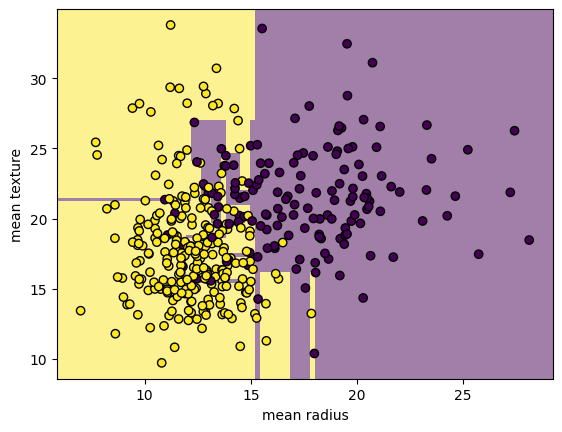

In [6]:
# display the decision boundary learned from the training dataset
# plot decision boundary
disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    response_method = "predict",
    plot_method = "pcolormesh",
    xlabel = 'mean radius',
    ylabel = 'mean texture',
    shading = "auto",
    alpha = 0.5
)
# plot training data points
disp.ax_.scatter(
    X_train[:, 0],
    X_train[:, 1],
    c = y_train,
    edgecolors = 'k'
)
plt.show()

From the displayed deicsion boundary we can find, the feature space is divided into many fragmented parts.

In some parts, there is only one data points, which indicated we might get an over-fitted model.

We can display the learned decision tree to check if there is an over-fitting.

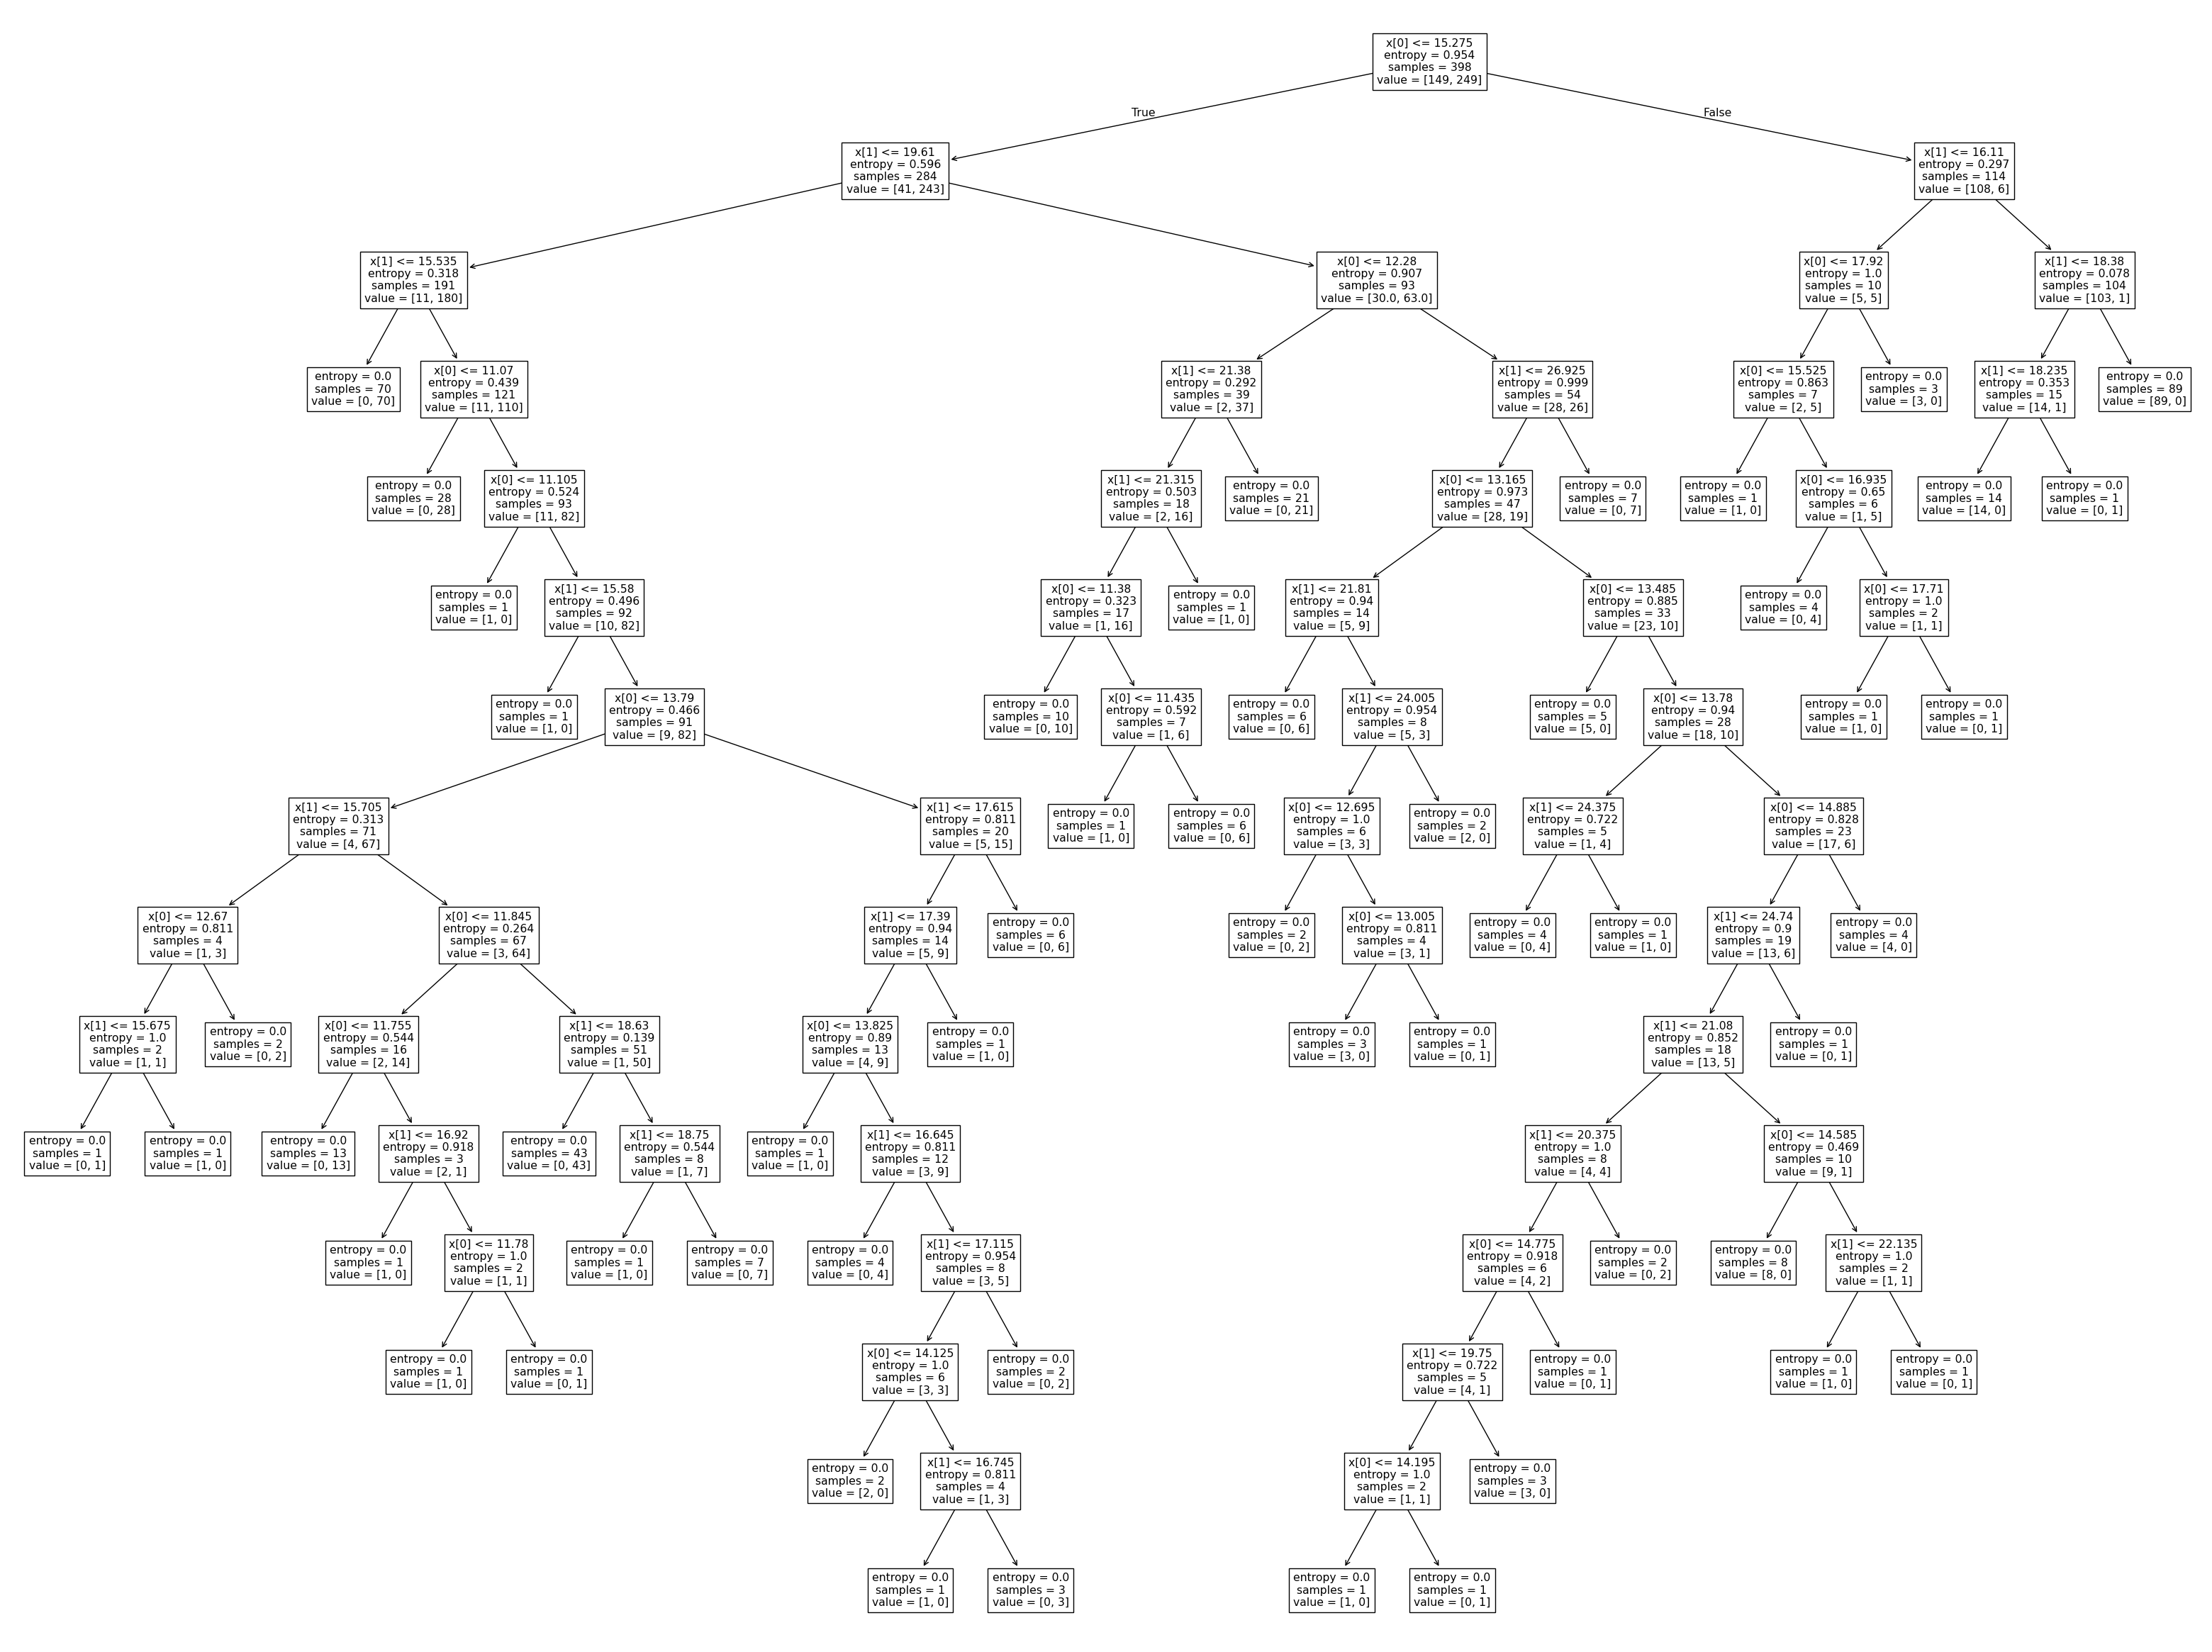

In [7]:
# plot the tree structure
plt.figure(figsize = [40, 30])
plot_tree(clf)
plt.show()

From the displayed decision tree we can find, all leaf nodes are pure nodes.

Most of the leaf nodes only contain one data point, which indicated there is an over-fitting.

We need to pruning the tree to avoid that.

`sklearn.tree.DecisionTreeClassifier` performs pre-pruning by setting different restriction hyper-parameters.

For example, we can limit the maximum depth of the tree.

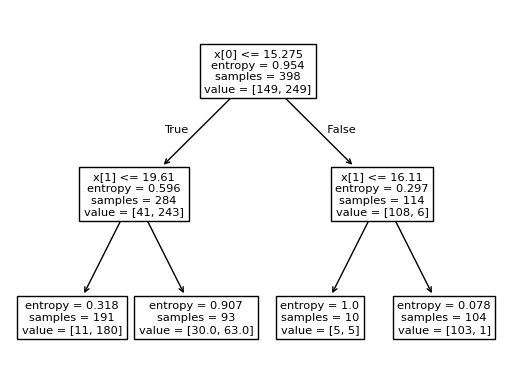

In [8]:
# pre-pruning by limiting the max depth of the tree
clf = DecisionTreeClassifier(
    criterion = 'entropy', # use information gain as the criterion
    max_depth = 2
)
clf.fit(X_train, y_train)
# plot the tree structure
plot_tree(clf)
plt.show()

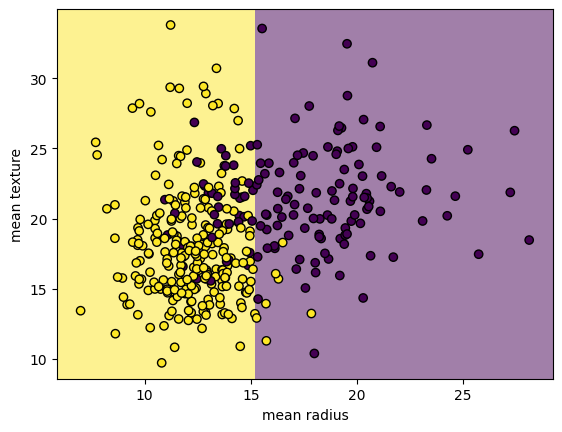

In [9]:
# display the decision boundary learned from the training dataset
# plot decision boundary
disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train,
    response_method = "predict",
    plot_method = "pcolormesh",
    xlabel = 'mean radius',
    ylabel = 'mean texture',
    shading = "auto",
    alpha = 0.5
)
# plot training data points
disp.ax_.scatter(
    X_train[:, 0],
    X_train[:, 1],
    c = y_train,
    edgecolors = 'k'
)
plt.show()

### Evaluate the model

In [10]:
# predict categories for testing dataset
y_pred = clf.predict(X_test)

In [11]:
# predict probabilities for test dataset
y_pred_proba = clf.predict_proba(X_test)
# show the first 5 predicted probability
y_pred_proba[:5, :]

array([[0.32258065, 0.67741935],
       [0.32258065, 0.67741935],
       [0.05759162, 0.94240838],
       [0.05759162, 0.94240838],
       [0.05759162, 0.94240838]])

In [12]:
# get all metrics using `classification_report`
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.73      0.83        63
           1       0.86      0.98      0.92       108

    accuracy                           0.89       171
   macro avg       0.91      0.86      0.87       171
weighted avg       0.90      0.89      0.88       171



## Part 2. Hyper-parameter tuning through cross-validation

In this part, we will perform hyper-parameter tuning for the decision tree classifier through 3-fold cross-validation to improve the model's performance.

A search consists of:

- a model (the decision tree classifier);
- a hyper-parameter space (the values of hyper-parameters to search);
- a method for searching or sampling candidates (grid search or random search);
- a cross-validation scheme (3-fold cross-validation); and
- a score function (performance metric to compare different hyper-parameter combinations).

### Grid search

Let's first try the grid search strategy using `sklearn.model_selection.GridSearchCV`.

`sklearn.model_selection.GridSearchCV` will trained a set of models with the same dataset (training and validation) but different hyper-parameters.

We can specify `refit = True` to retrain a best model using the best hyper-parameters find by grid search and also the entire training dataset (no fold left for validation).

We can get this best model by the attribute `GridSearchCV.best_estimator_`.

In [13]:
# define the hyper-parameters dictionary for grid search
param_dict = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [2, 3, 4],
    'min_impurity_decrease': [0.0, 0.1, 0.2]
}
# NEED TO UNDERSTAND THE PARAMETERS AS IS YOU WHO MANUALLY PUT THE VALUES IN THE DICTIONARY.
# Max depth start with a large range and go smaller -> Step by step. Usually 3 

In [14]:
# hyper-parameter tuning through grid search cross-validation
grid_clf = GridSearchCV(
    estimator = DecisionTreeClassifier(),
    param_grid = param_dict,
    scoring = 'f1_weighted',
    refit = True,
    cv = 3, #WHAT?
    verbose = 5 #Summarize of the process done in the grid. Just about the output. 
)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END criterion=gini, max_depth=2, min_impurity_decrease=0.0;, score=0.876 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=2, min_impurity_decrease=0.0;, score=0.861 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=2, min_impurity_decrease=0.0;, score=0.845 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=2, min_impurity_decrease=0.1;, score=0.876 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=2, min_impurity_decrease=0.1;, score=0.861 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=2, min_impurity_decrease=0.1;, score=0.839 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=2, min_impurity_decrease=0.2;, score=0.876 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=2, min_impurity_decrease=0.2;, score=0.861 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=2, min_impurity_decrease=0.2;, score=0.839 total time=   0.0s
[CV 1/3] END criterion=gini, m

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 3, 4],
                         'min_impurity_decrease': [0.0, 0.1, 0.2]},
             scoring='f1_weighted', verbose=5)

In [15]:
# obtain the best hyper-parameters the best score
print('Best hyper-parameters:', grid_clf.best_params_)
print('Best score:', grid_clf.best_score_)

Best hyper-parameters: {'criterion': 'gini', 'max_depth': 3, 'min_impurity_decrease': 0.0}
Best score: 0.8727488059454654


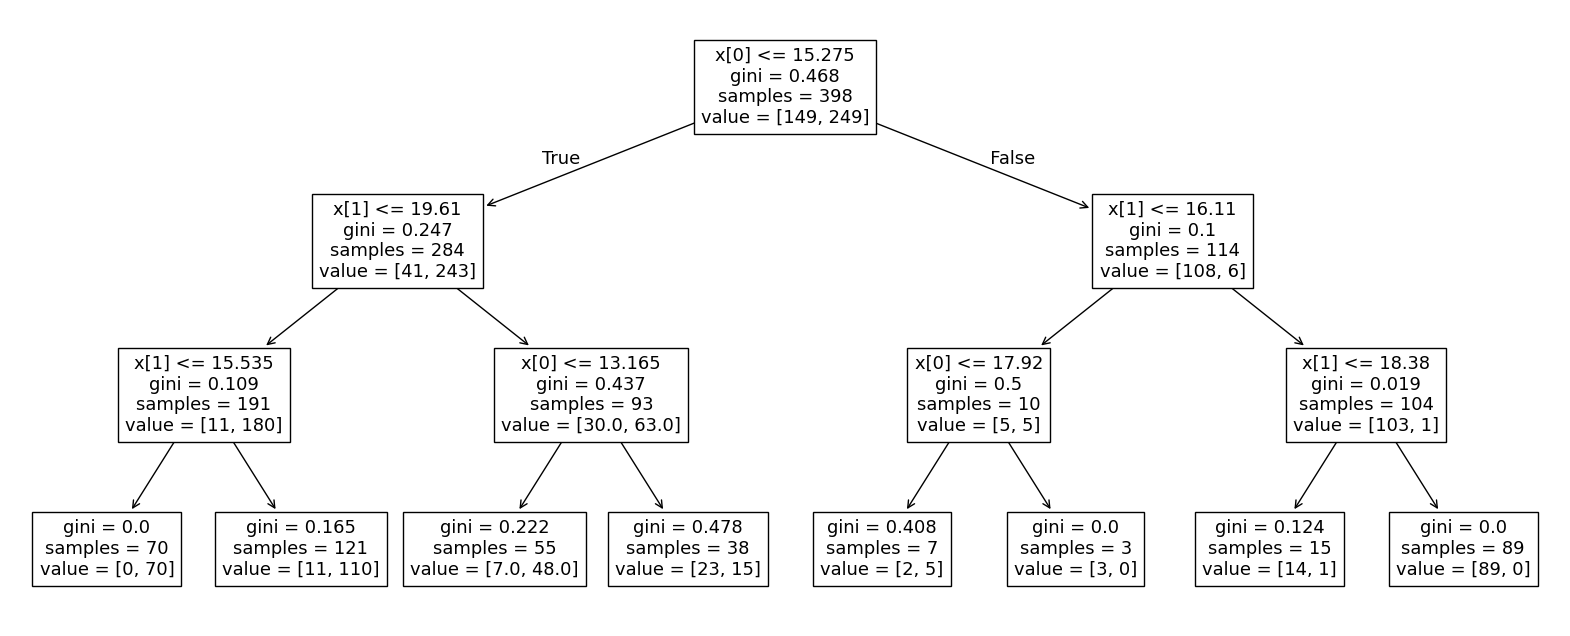

In [16]:
# obtain the best estimator
plt.figure(figsize = [20, 8])
plot_tree(grid_clf.best_estimator_)
plt.show()

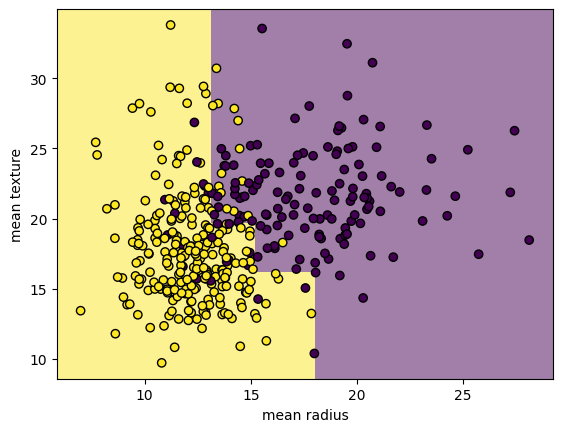

In [17]:
# display the decision boundary learned from the training dataset
# plot decision boundary
disp = DecisionBoundaryDisplay.from_estimator(
    grid_clf.best_estimator_,
    X_train,
    response_method = "predict",
    plot_method = "pcolormesh",
    xlabel = 'mean radius',
    ylabel = 'mean texture',
    shading = "auto",
    alpha = 0.5
)
# plot training data points
disp.ax_.scatter(
    X_train[:, 0],
    X_train[:, 1],
    c = y_train,
    edgecolors = 'k'
)
plt.show()

In [18]:
# predict categories for test dataset
y_pred = grid_clf.predict(X_test)
# get all metrics using `classification_report`
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87        63
           1       0.94      0.90      0.92       108

    accuracy                           0.90       171
   macro avg       0.89      0.90      0.89       171
weighted avg       0.90      0.90      0.90       171



### Random search

Now let's try the random search strategy using `sklearn.model_selection.RandomizedSearchCV`.

In contrast to `GridSearchCV`, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by `n_iter`.

In [19]:
# define the hyper-parameters to search
param_distributions = dict(
    criterion = ['gini', 'entropy', 'log_loss'],
    max_depth = randint(low = 2, high = 5), # Probability distribution
    min_impurity_decrease = uniform() #uniform distribution between 0 and 1
) # Add flexibility to the use of the parameters.

In [20]:
# hyper-parameter tuning through random search cross-validation
rand_clf = RandomizedSearchCV(
    estimator = DecisionTreeClassifier(),
    param_distributions = param_distributions,
    n_iter = 10,
    scoring = 'f1_weighted',
    refit = True,
    cv = 3,
    verbose = 10,
    random_state = 0, #Control the random seed.
)
rand_clf.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START criterion=gini, max_depth=3, min_impurity_decrease=0.8442657485810173
[CV 1/3; 1/10] END criterion=gini, max_depth=3, min_impurity_decrease=0.8442657485810173;, score=0.480 total time=   0.0s
[CV 2/3; 1/10] START criterion=gini, max_depth=3, min_impurity_decrease=0.8442657485810173
[CV 2/3; 1/10] END criterion=gini, max_depth=3, min_impurity_decrease=0.8442657485810173;, score=0.480 total time=   0.0s
[CV 3/3; 1/10] START criterion=gini, max_depth=3, min_impurity_decrease=0.8442657485810173
[CV 3/3; 1/10] END criterion=gini, max_depth=3, min_impurity_decrease=0.8442657485810173;, score=0.485 total time=   0.0s
[CV 1/3; 2/10] START criterion=entropy, max_depth=3, min_impurity_decrease=0.3843817072926998
[CV 1/3; 2/10] END criterion=entropy, max_depth=3, min_impurity_decrease=0.3843817072926998;, score=0.876 total time=   0.0s
[CV 2/3; 2/10] START criterion=entropy, max_depth=3, min_impurity_decrease=0.3843

RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1171febd0>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1171fcc80>},
                   random_state=0, scoring='f1_weighted', verbose=10)

In [21]:
# obtain the best hyper-parameters the best score
print('Best hyper-parameters:', rand_clf.best_params_)
print('Best score:', rand_clf.best_score_)

Best hyper-parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_impurity_decrease': np.float64(0.3843817072926998)}
Best score: 0.8584993487394242


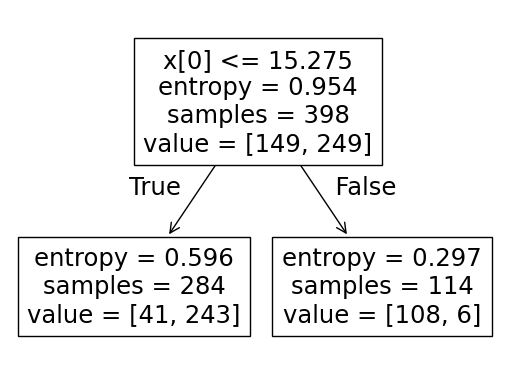

In [22]:
# obtain the best estimator
plt.figure()
plot_tree(rand_clf.best_estimator_)
plt.show()

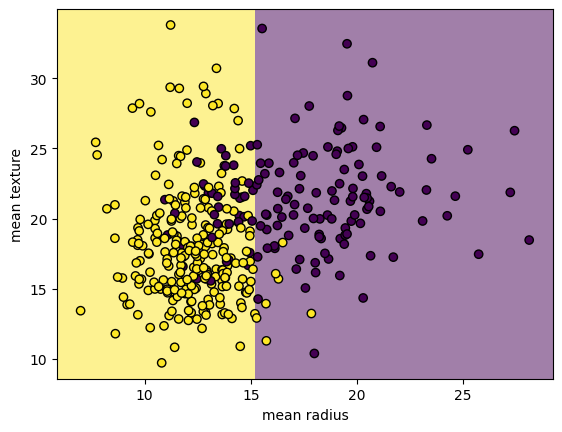

In [23]:
# display the decision boundary learned from the training dataset
# plot decision boundary
disp = DecisionBoundaryDisplay.from_estimator(
    rand_clf.best_estimator_,
    X_train,
    response_method = "predict",
    plot_method = "pcolormesh",
    xlabel = 'mean radius',
    ylabel = 'mean texture',
    shading = "auto",
    alpha = 0.5
)
# plot training data points
disp.ax_.scatter(
    X_train[:, 0],
    X_train[:, 1],
    c = y_train,
    edgecolors = 'k'
)
plt.show()

In [24]:
# predict categories for test dataset
y_pred = rand_clf.predict(X_test)
# get all metrics using `classification_report`
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.73      0.83        63
           1       0.86      0.98      0.92       108

    accuracy                           0.89       171
   macro avg       0.91      0.86      0.87       171
weighted avg       0.90      0.89      0.88       171



If you are not happy with the random results try: change the distribution or increase the number of combination to get better results. Maybe the parameters are not the most optimal ones.

## Part 3. Hands-on exercise

In this exercise, we will build a multi-class classifier with the the [California Housing dataset](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset).

The goal of the classifier is to perform a multi-class classification taks:
- 0 represents 'Low Price', 'MedHouseVal' < 1
- 1 represents 'Normal Price', 1 <= 'MedHouseVal' <= 2.5
- 2 represents 'Expensive Price', 'MedHouseVal' > 2.5

<span style="color:red">**[TBC]**</span> Please complete the following steps:
- Build the classifier using decision tree.
- Perform hyper-parameter tuning through cross-validation to improve model's performance.
    - Use grid search strategy `sklearn.model_selection.GridSearchCV`
    - Use random search strategy `sklearn.model_selection.RandomizedSearchCV`

### Task 1. Load, pre-process, and split the dataset

<span style="color:red">**[TBC]**</span> Please complete the following steps:
- Load the dataset
- Construct the new multi-class target variable use `MedHouseVal` as reference
- Split the dataset into training and testing sets

In [25]:
# [TBC] complete your code here with proper comments
data = datasets.fetch_california_housing()
data_df = pd.DataFrame(data.data,columns=data.feature_names)
data_df['MedHouseVal'] = data.target
data_df.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal'],
      dtype='object')

In [26]:
# Define the conditions
conditions = [
    data_df['MedHouseVal'] < 1,
    (data_df['MedHouseVal'] >= 1) & (data_df['MedHouseVal'] <= 2.5),
    data_df['MedHouseVal'] > 2.5
]

# Define the corresponding class labels
choices = [0, 1, 2]
#Low, Normal and Expensive price.

# Create the new target variable
data_df['PriceCategory'] = np.select(conditions, choices)

print(data_df['PriceCategory'].value_counts())

PriceCategory
1    11262
2     5782
0     3596
Name: count, dtype: int64


In [27]:
# Define features (X) and target (y)
target_df = data_df['PriceCategory']
feature_df = data_df.drop(['MedHouseVal', 'PriceCategory'], axis=1)

feature_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [ ]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    feature_df.values,
    target_df.values,
    train_size = 0.7,
    shuffle = True,
    random_state = 42
)

### Task 2. Hyper-parameter tuning using grid search strategy

<span style="color:red">**[TBC]**</span> Please complete the following steps:
- Define the hyper-parameters to search
    - `criterion` = Specifies the function to measure the quality of a split in a Decision Tree.
    - `max_depth` = Maximum depth of the tree. Limits the number of splits the tree can make down any branch.
    - `min_samples_split` = Minimum number of samples required to split an internal node.
    - `min_samples_leaf` = Minimum number of samples required to be at a leaf node.
    - `max_features` = The number of features to consider when looking for the best split.
    - `min_impurity_decrease` = A node will split only if the decrease in impurity (e.g., Gini or entropy) is at least this value.
- Perform grid search with cross-validation
    - Check the best estimator and the best score
    - If needed, refine the hyper-parameters to search, redo the grid search
    - If good enough, continue with the best hyper-parameters found by the grid search
- Train the model with the best hyper-parameters
- Evaluate the performance with the test dataset

In [103]:
# [TBC] complete your code here with proper comments
param_dict = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [8, 9, 10],
    'min_impurity_decrease': [0.0, 0.1, 0.2]
}

In [104]:
# hyper-parameter tuning through grid search cross-validation
grid_clf = GridSearchCV(
    estimator = DecisionTreeClassifier(),
    param_grid = param_dict,
    scoring = 'f1_weighted',
    refit = True,
    cv = 3, #Specifies the number of cross-validation folds
    verbose = 5 #Summarize of the process done in the grid. Just about the output. 
)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END criterion=gini, max_depth=8, min_impurity_decrease=0.0;, score=0.773 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=8, min_impurity_decrease=0.0;, score=0.770 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=8, min_impurity_decrease=0.0;, score=0.772 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=8, min_impurity_decrease=0.1;, score=0.385 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=8, min_impurity_decrease=0.1;, score=0.385 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=8, min_impurity_decrease=0.1;, score=0.384 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=8, min_impurity_decrease=0.2;, score=0.385 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=8, min_impurity_decrease=0.2;, score=0.385 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=8, min_impurity_decrease=0.2;, score=0.384 total time=   0.0s
[CV 1/3] END criterion=gini, m

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [8, 9, 10],
                         'min_impurity_decrease': [0.0, 0.1, 0.2]},
             scoring='f1_weighted', verbose=5)

In [105]:
# obtain the best hyper-parameters the best score
print('Best hyper-parameters:', grid_clf.best_params_)
print('Best score:', grid_clf.best_score_)

Best hyper-parameters: {'criterion': 'gini', 'max_depth': 10, 'min_impurity_decrease': 0.0}
Best score: 0.7735094033614485


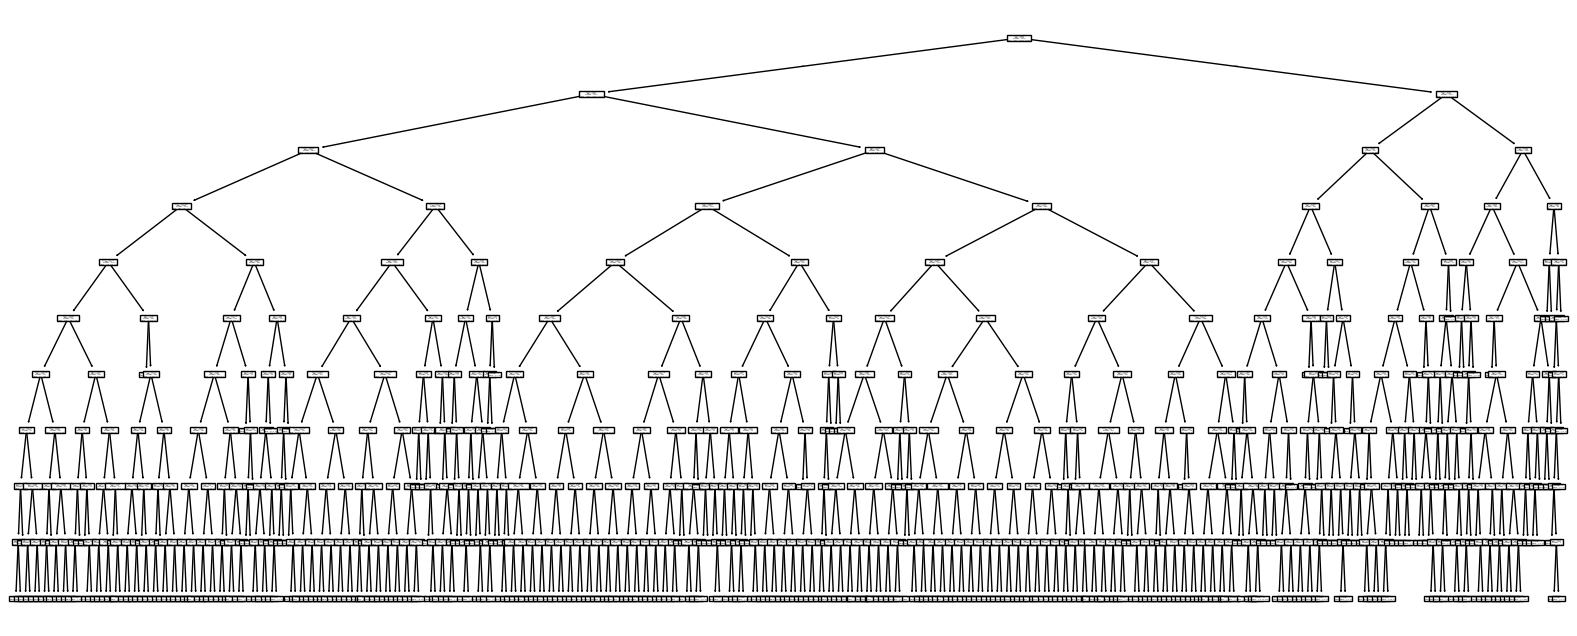

In [106]:
# obtain the best estimator
plt.figure(figsize = [20, 8])
plot_tree(grid_clf.best_estimator_)
plt.show()

In [107]:
# predict categories for test dataset
y_pred = grid_clf.predict(X_test)
# get all metrics using `classification_report`
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.69      0.73      1069
           1       0.79      0.83      0.81      3388
           2       0.77      0.74      0.75      1736

    accuracy                           0.78      6193
   macro avg       0.78      0.75      0.76      6193
weighted avg       0.78      0.78      0.78      6193



In [ ]:
# Doing a high fit grid classifier to see if is worth.
param_dict = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': range(2,10),
    'min_impurity_decrease': np.linspace(0.0, 0.1, 0.2), #Increase granularity
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 5),
    'max_features': [None, 'sqrt', 'log2'], #control the number of features considered at each split
}

grid_clf = GridSearchCV(
    estimator = DecisionTreeClassifier(),
    param_grid = param_dict,
    scoring = 'f1_weighted',
    refit = True,
    cv = 5, #fold cross-validation
    verbose = 1 #Summarize of the process done in the grid. Just about the output. 
)
grid_clf.fit(X_train, y_train)

print('Best hyper-parameters:', grid_clf.best_params_)
print('Best score:', grid_clf.best_score_)

# predict categories for test dataset
y_pred = grid_clf.predict(X_test)
# get all metrics using `classification_report`
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 25920 candidates, totalling 129600 fits
Best hyper-parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_impurity_decrease': np.float64(0.0), 'min_samples_leaf': 2, 'min_samples_split': 7}
Best score: 0.7787763619744568
              precision    recall  f1-score   support

           0       0.77      0.69      0.73      1069
           1       0.79      0.83      0.81      3388
           2       0.77      0.74      0.75      1736

    accuracy                           0.78      6193
   macro avg       0.77      0.75      0.76      6193
weighted avg       0.78      0.78      0.78      6193



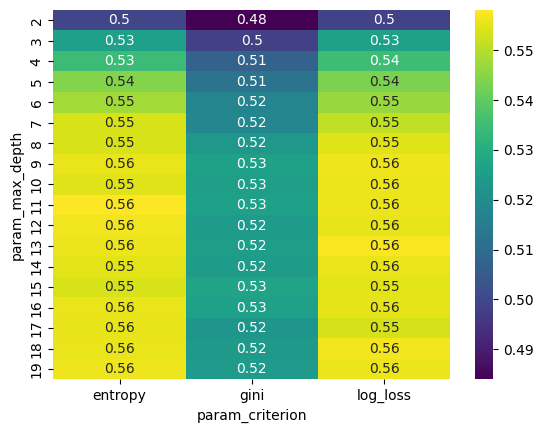

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt
results = pd.DataFrame(grid_clf.cv_results_)
pivot_table = results.pivot_table(index='param_max_depth', columns='param_criterion', values='mean_test_score')
sns.heatmap(pivot_table, annot=True, cmap='viridis')
plt.show()

This graph shows the results to by using the different criteria methods.

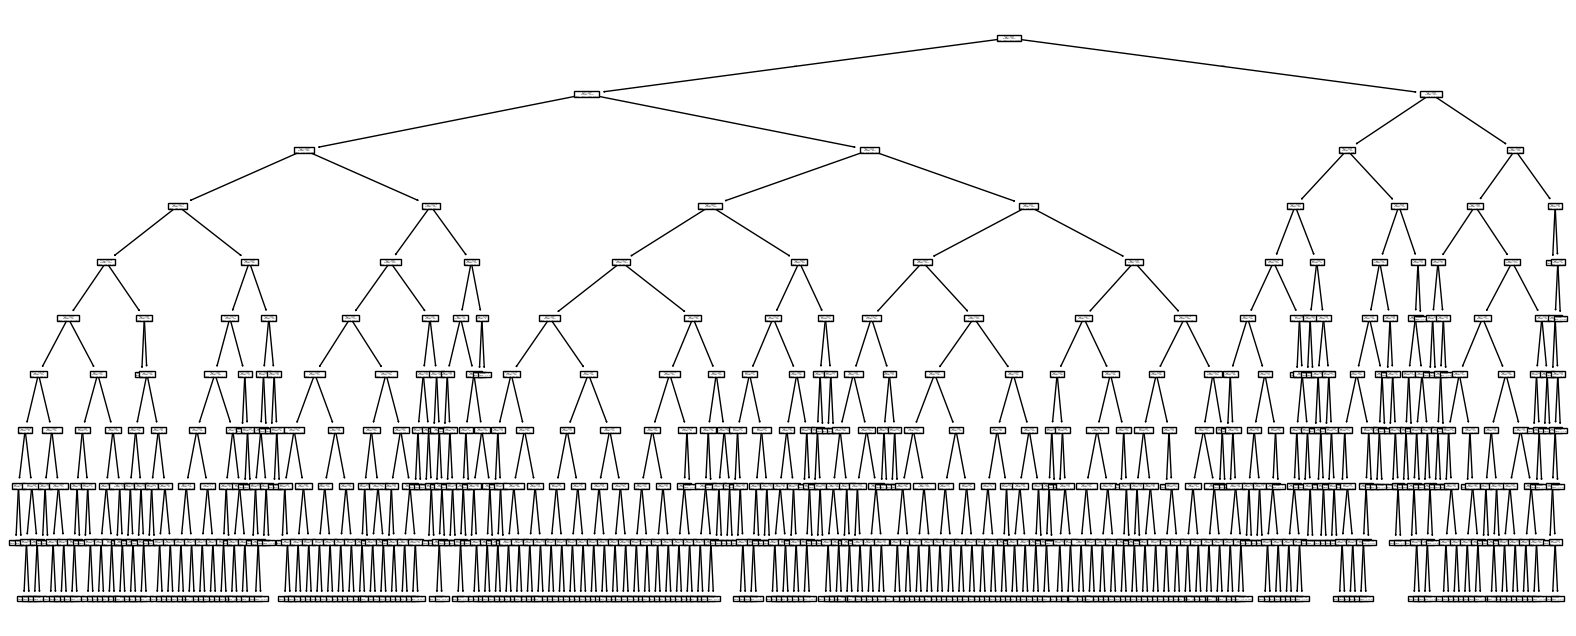

In [133]:
# obtain the best estimator
plt.figure(figsize = [20, 8])
plot_tree(grid_clf.best_estimator_)
plt.show()

### Conclusion:

The results for this Decision Tree were as follow:
- For the low grid iterations:

           -       precision recall  f1-score   support
           0       0.78      0.69      0.73      1069
           1       0.79      0.83      0.81      3388
           2       0.77      0.74      0.75      1736
         accuracy  -         -         0.78      6193
         mac avg   0.78      0.75      0.76      6193
         w avg     0.78      0.78      0.78      6193

- For the high grid iterations:

           -      precision  recall  f1-score   support
           0       0.77      0.69      0.73      1069
           1       0.79      0.83      0.81      3388
           2       0.77      0.74      0.75      1736
         accuracy  -         -         0.78      6193
         macro avg 0.77      0.75      0.76      6193
         w avg     0.78      0.78      0.78      6193

As seen, they were the same exact results, so in this case was not worth the usage of a high number of iterations.

### Task 3. Hyper-parameter tuning using random search strategy

Instead of perform an exhausive grid search, using random search strategy instead.

<span style="color:red">**[TBC]**</span> Please complete the following steps:
- Define the hyper-parameters to search
- Perform random search with cross-validation
- Train the model with the best hyper-parameters
- Evaluate the performance with the test dataset

In [134]:
# [TBC] complete your code here with proper comments
# Redefine the hyper-parameters to search
param_distributions = dict(
    criterion = ['gini', 'entropy', 'log_loss'],
    max_depth = randint(low = 2, high = 20), # Probability distribution
    min_impurity_decrease = uniform(0,0.1), #uniform distribution between 0 and 1
    min_samples_split = randint(low = 2, high = 20), #The minimum number of samples required to split an internal node
    min_samples_leaf = randint(1, 10), #The minimum number of samples required to be at a leaf node.
    max_features = ['sqrt', 'log2', None] #Number of features to consider when looking for the best split
) # Add flexibility to the use of the parameters.

rand_clf = RandomizedSearchCV(
    estimator = DecisionTreeClassifier(),
    param_distributions = param_distributions,
    n_iter = 100,
    scoring = 'f1_weighted',
    refit = True,
    cv = 3,
    verbose = 1,
    random_state = 0, #Control the random seed.
)
rand_clf.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_iter=100,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x174c750d0>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x14f3f6ed0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1749b76b0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x168084560>},
                   random_state=0, scoring='f1_weighted', verbose=1)

In [135]:
# obtain the best hyper-parameters the best score
print('Best hyper-parameters:', rand_clf.best_params_)
print('Best score:', rand_clf.best_score_)

Best hyper-parameters: {'criterion': 'log_loss', 'max_depth': 19, 'max_features': None, 'min_impurity_decrease': np.float64(0.001142745862503103), 'min_samples_leaf': 4, 'min_samples_split': 14}
Best score: 0.7782560987920144


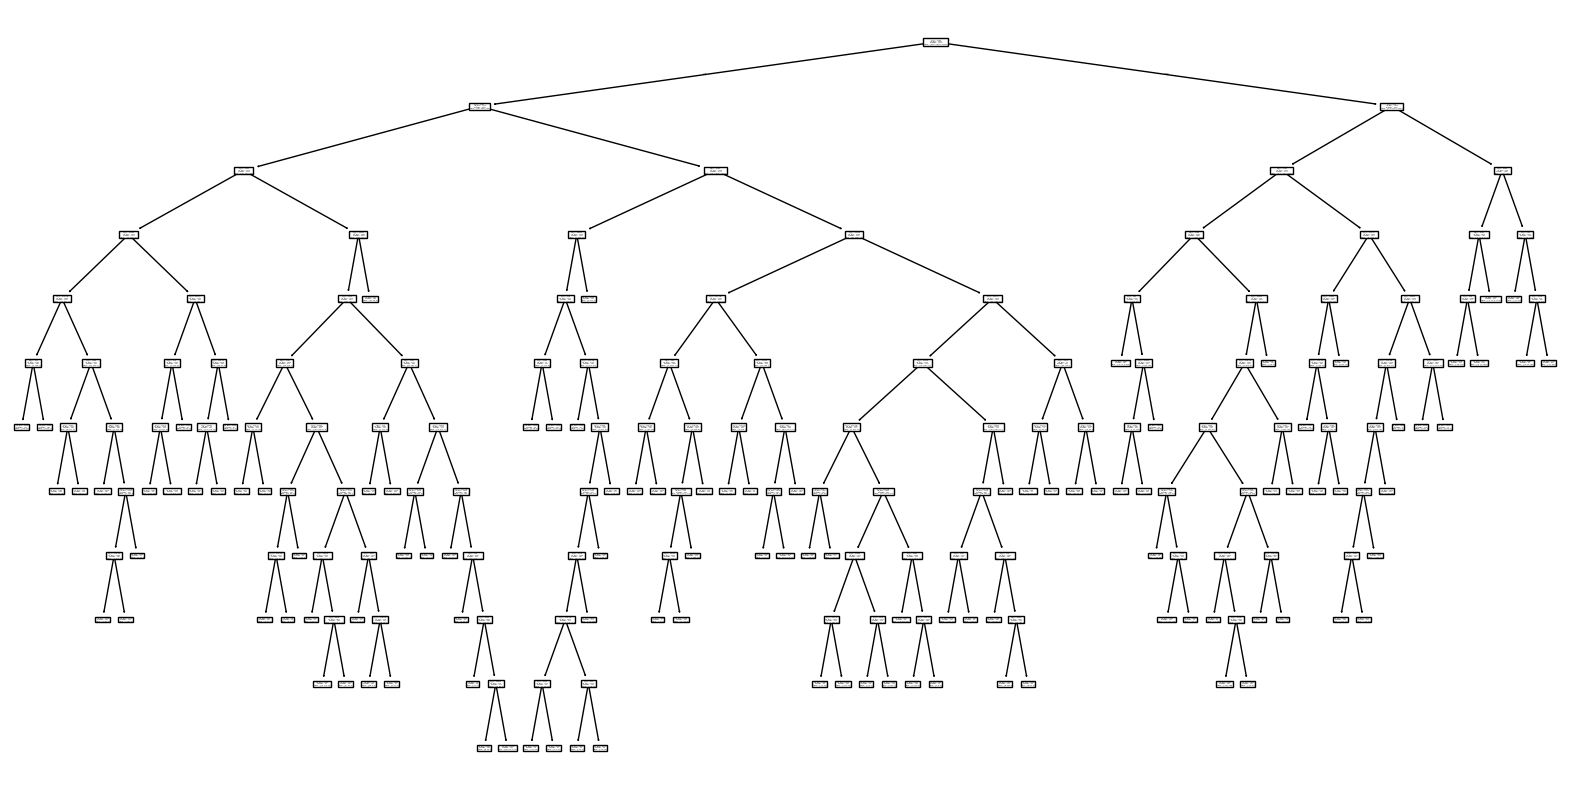

In [137]:
# obtain the best estimator
plt.figure(figsize = [20, 10])
plot_tree(rand_clf.best_estimator_)
plt.show()

In [128]:
# predict categories for test dataset
y_pred = rand_clf.predict(X_test)
# get all metrics using `classification_report`
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.65      0.68      1069
           1       0.77      0.84      0.80      3388
           2       0.80      0.71      0.75      1736

    accuracy                           0.77      6193
   macro avg       0.76      0.73      0.75      6193
weighted avg       0.77      0.77      0.77      6193



### Conclusion:

By using the random search strategy, the results were just slightly worst than the grid version, but the amount of time and resources is highly different.

- Random search:

        accuracy         0.77 
        macro avg        0.75 
        weighted avg     0.77 

- Grid results:

        accuracy         0.78 
        macro avg        0.76 
        w avg            0.78 

Given the minimal performance gap, Random Search is a more practical choice when computational efficiency is important.